# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.

In [14]:
# Setup and import everything
%matplotlib notebook

import pandas as pd
import yaml

from os import getcwd, listdir
from os.path import join, isdir

from processor import analysis, reports

from IPython.display import display

base_directory = join(getcwd(), 'batch-test-reports')
with open(join(base_directory, 'description.yml')) as fp:
    batch_description = yaml.load(fp)
batch_description

{'connection_speed': 1500,
 'experiment': [{'lapse': 3600, 'speed': 1500, 'start': 1511625600},
  {'lapse': 3600, 'speed': 1125, 'start': 1511629200},
  {'lapse': 3600, 'speed': 750, 'start': 1511632800},
  {'lapse': 3600, 'speed': 375, 'start': 1511636400},
  {'lapse': 3600, 'speed': 0, 'start': 1511640000}]}

In [9]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    for experiment_configuration in batch_description['experiment']:
        start = experiment_configuration['start']
        lapse = experiment_configuration['lapse']
        if start <= batch_start_time < start + lapse:
            batch_starting_conf = experiment_configuration
        if start <= batch_end_time < start + lapse:
            batch_ending_conf = experiment_configuration
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
    if batch_starting_conf is None and batch_ending_conf is None:
        raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
                                                                                          batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed'] / batch_description['connection_speed']
    elif batch_starting_conf['speed'] == batch_ending_conf['speed']:
        expected_usage = batch_starting_conf['speed'] / batch_description['connection_speed']
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf['start'] + batch_starting_conf['lapse'] - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf['start']
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed'] +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed']) / batch_description['connection_speed']
    return expected_usage
    

In [23]:
columns = ['batch_start_time', 'batch_end_time', 
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in listdir(base_directory):
    reports_batch_dir_path = join(base_directory, reports_batch_dir)
    if not isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage)
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

1511632791 1511633710 919 9 910 1125 750 0.5024483133841131
1511628721 1511629507 786 479 307 1500 1125 0.9023536895674301
1511635607 1511636539 932 793 139 750 375 0.46271459227467815
1511632242 1511632898 656 558 98 1125 750 0.7126524390243901


,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage
0,1511625711,1511626743,0.586908,0.541456,1.0,0.106529,0.518946,0.621644,1.0,1.000000,1.000000
1,1511626270,1511626834,0.545624,0.475658,1.0,0.136752,0.525868,0.464402,1.0,0.661538,1.000000
2,1511626831,1511627692,0.506787,0.560314,1.0,0.815385,0.428194,0.498067,1.0,1.000000,1.000000
3,1511627395,1511628649,0.517431,0.355737,1.0,0.017510,0.506567,0.311682,1.0,0.371595,1.000000
4,1511628089,1511629127,0.547272,0.463268,1.0,0.901893,0.549535,0.471728,1.0,0.738382,1.000000
5,1511628721,1511629507,0.538868,0.464167,1.0,0.657407,0.540072,0.403842,1.0,0.642593,0.902354
6,1511631494,1511632478,0.575739,0.467750,1.0,0.356667,0.533716,0.472982,1.0,0.476667,0.750000
7,1511632242,1511632898,0.526591,0.613788,1.0,0.238333,0.556338,0.305974,1.0,0.470000,0.712652
8,1511632791,1511633710,0.570866,0.420682,1.0,0.345000,0.491011,0.382705,1.0,0.441667,0.502448
9,1511633340,1511634214,0.488297,0.465930,1.0,0.390572,0.472216,0.462985,1.0,0.553872,0.500000


<IPython.core.display.Javascript object>


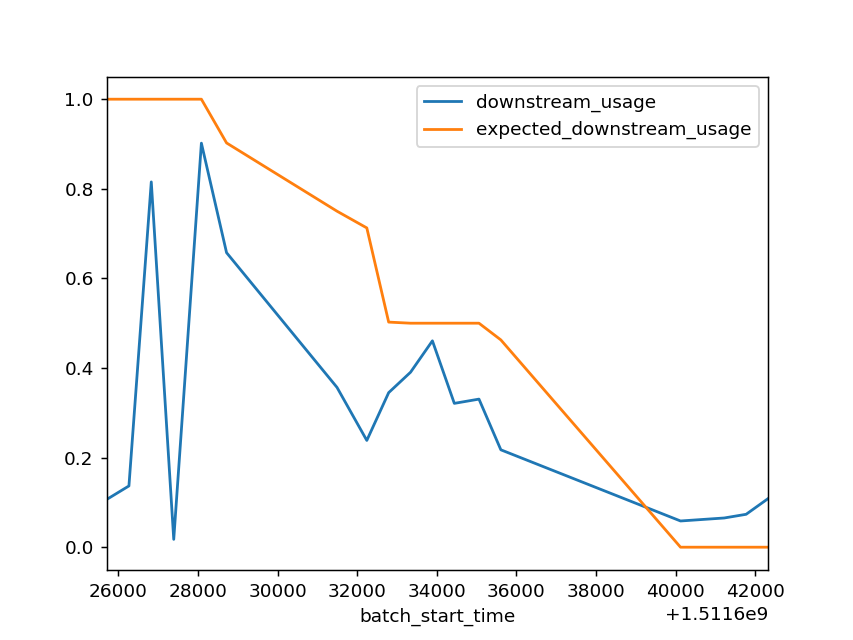

In [24]:
data.plot(x='batch_start_time', y=['downstream_usage', 'expected_downstream_usage'], kind='line')